In [1]:
# Python2.7 + pandas0.18.1 + numpy1.15.4 + matplotlib2.0.2 on CentOS7
from __future__ import division
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
home = os.getcwd()

### sigmod函数
$$h_\theta(x) = \frac{1}{1+e^{-\theta^Tx}}$$
### Cost Function
通过极大似然估计得到：
$$
\begin{equation}
Cost(h_\theta(x), y) = \begin{cases}
    -log(h_\theta(x)) & \text{if } y=1 \\
    -log(1-h_\theta(x)) & \text{if } y=0
\end{cases}
\end{equation}
$$
上述条件判断式可以简化为：
$$Cost(h_\theta(x), y) = -ylog(h_\theta(x)) - (1-y)log(1-h_\theta(x))$$
而通用意义上的代价函数是：
$$J(\theta, x) = \frac{1}{m}\sum_{i=1}^m Cost(h_\theta(x), y)$$
所以逻辑回归的代价函数为：
$$J(\theta, x) = -\frac{1}{m}\sum_{i=1}^m y^{(i)}log(h_\theta(x^{(i)})) + (1-y^{(i)})log(1-h_\theta(x^{(i)}))$$
该函数是个凸函数。   

最终目标是找到满足下列条件的参数$\theta$：      
&emsp;&emsp; $min_{\theta} J(\theta)$          
想要最小化$J(\theta)$，则重复下面的过程：
$$\theta_j := \theta_j - \alpha\frac{\partial}{\partial\theta_j}J(\theta)$$
$J(\theta)$的对$\theta$偏导数为：
$$\frac{\partial}{\partial\theta_j}J(\theta) = \frac{1}{m}\sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$$
所以
$$\theta_j := \theta_j - \alpha\sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$$

### Logistic回归代价函数的求导过程
 - https://blog.csdn.net/The_lastest/article/details/78761577
<img src=http://images2015.cnblogs.com/blog/957212/201702/957212-20170215231609972-1580739215.png></img>
 - https://blog.csdn.net/Mr_HHH/article/details/78934793     
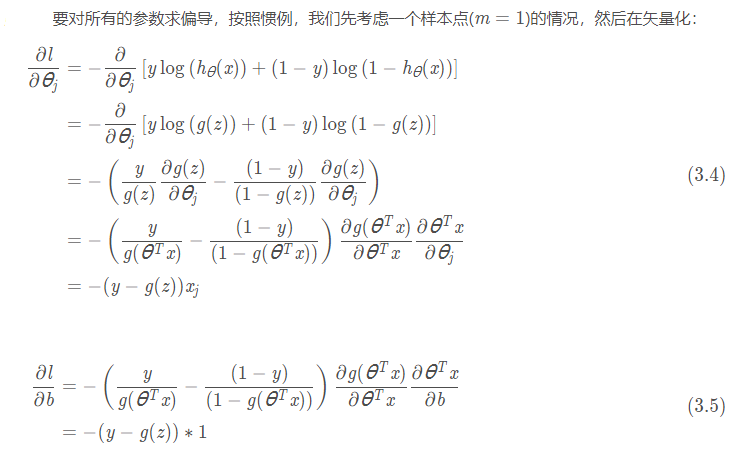

这儿用的是$g(z)=\frac{1}{1+exp(−z)}$，同样还可以是$tanh(z)$,但是选取前者主要是因为其求导之后的结果为$g'(z)=g(z)(1−g(z))$便于化简。

# Logistic Regression

In [5]:
data1 = pd.read_csv(os.path.join(home, "ex2data1.txt"), names=["exam1score", "exam2score", "admitted"])
data1.tail()

,exam1score,exam2score,admitted
95,83.489163,48.380286,1
96,42.261701,87.103851,1
97,99.315009,68.775409,1
98,55.340018,64.931938,1
99,74.775893,89.529813,1


## 展示正负数据

In [12]:
pos = data1[data1["admitted"] == 1]
neg = data1[data1["admitted"] == 0]

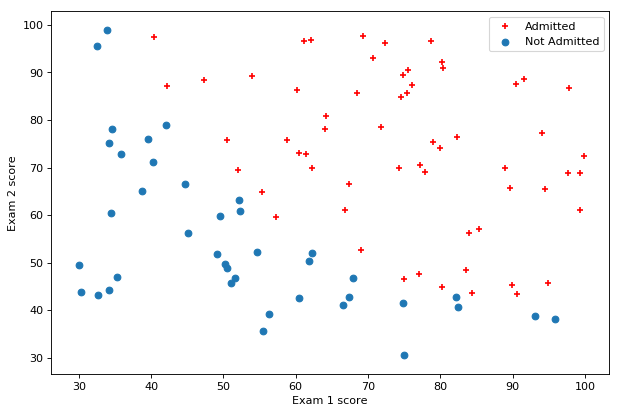

In [22]:
%matplotlib inline

plt.figure(figsize=(9,6), dpi= 80)
plt.scatter(pos.exam1score, pos.exam2score, c='red', marker='+', label="Admitted")
plt.scatter(neg.exam1score, neg.exam2score, label="Not Admitted")
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend()

## 生成训练数据X,y，并转换成np.ndarray类型

In [25]:
X = data1[["exam1score", "exam2score"]]
X.insert(0,"ones", np.ones(X.shape[0]))       # DataFrame.insert(loc, column, value, allow_duplicates=False)
X.tail()

,ones,exam1score,exam2score
95,1.0,83.489163,48.380286
96,1.0,42.261701,87.103851
97,1.0,99.315009,68.775409
98,1.0,55.340018,64.931938
99,1.0,74.775893,89.529813


In [30]:
X = np.array(X)
X[0:5]         # head of X

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644]])

In [39]:
# y = np.array(data1["admitted"])        # 生成简单类似list结构的array，例如array([0, 0, 0, 1, 1, 0, 1, 1, 1,...])
y = np.array(data1["admitted"]).reshape(-1, 1)
y[0:5]

array([[0],
       [0],
       [0],
       [1],
       [1]])

In [40]:
X.shape, y.shape

((100, 3), (100, 1))

## 定义sigmoid、cost、batch梯度下降函数

In [543]:
import math

def sigmoid(X, theta):
    return 1/(1 + np.exp(np.dot(-X, theta)))

def compute_cost(X, y, theta):
    m = X.shape[0]
    h = sigmoid(X, theta)
    errors = -y*np.log(h) - (1-y)*np.log(1-h)
    j = np.sum(errors) / m
    return j

def batch_gradient_descent(X, y, theta, alpha, iterations):
    costs = []
    m = X.shape[0]
    for i in range(iterations):
        errors = np.dot(X.T, sigmoid(X, theta) - y) 
        theta -= alpha * errors / m
        costs.append(compute_cost(X, y, theta))
    return theta, costs

In [241]:
th1 = np.zeros(X.shape[1]).reshape(-1,1)
print("zeros theta cost: %f" % compute_cost(X, y, th1))      # Cost at initial theta (zeros)

zeros theta cost: 0.693147


### 逻辑回归梯度下降收敛速度特别慢!!!
 - 学习率 alpha>=0.005时，迭代次数为100,000时，根本不收敛
 - 学习率越大，收敛所需的迭代次数越多，可能需要上百万次，时间上根本没法接受

In [242]:
# 例如alpha = 0.01时，iterations=1,000,000时，能从cost后10个值看出依然在震荡，且无法进一步优化
_theta_ = np.zeros(X.shape[1]).reshape(-1,1)
_alpha_ = 0.01
_iterations_ = 1000000
_theta_, _costs_ = batch_gradient_descent(X, y, _theta_, _alpha_, _iterations_)
print(_theta_)
print(_costs_[-10:-1])

[[-59.19195392]
 [  0.49710163]
 [  0.48979407]]
[0.32067498764837843, 0.3297800869126999, 0.32067621859912504, 0.32978187451664964, 0.32067744955518557, 0.32978366214237825, 0.32067868051656, 0.32978544978988317, 0.32067991148325065]


In [237]:
# 当alpha=0.004，iterations=300000时，theta和cost与Matlab计算结果相近

In [233]:
theta = np.zeros(X.shape[1]).reshape(-1,1)
alpha = 0.004
iterations = 300000

In [234]:
theta, costs = batch_gradient_descent(X, y, theta, alpha, iterations)
theta

array([[-24.08758741],
       [  0.19764452],
       [  0.19278233]])

In [235]:
compute_cost(X, y, theta)

0.20367566642563

Matlab计算结果
```
Cost at theta found by fminunc: 0.203498
Expected cost (approx): 0.203
theta:
 -25.161272
 0.206233
 0.201470
Expected theta (approx):
 -25.161
 0.206
 0.201
 ```

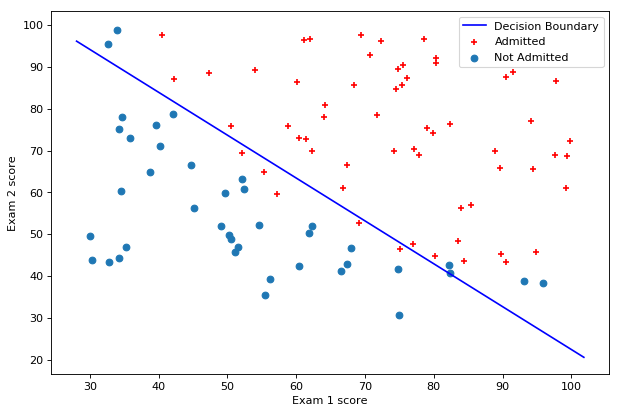

In [238]:
%matplotlib inline

plt.figure(figsize=(9,6), dpi= 80)
plt.scatter(pos.exam1score, pos.exam2score, c='red', marker='+', label="Admitted")
plt.scatter(neg.exam1score, neg.exam2score, label="Not Admitted")
##### 仿照`plotDecisionBoundary.m`中的程序计算决策分界线，目前不知道为什么可以这么计算
plot_x = [min(X[:, 1])-2,  max(X[:, 1])+2]
plot_y = -1/theta[2] * (theta[1]*plot_x + theta[0])
plt.plot(plot_x, plot_y, c='blue', label="Decision Boundary")
#####
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend()

## 查看cost收敛情况

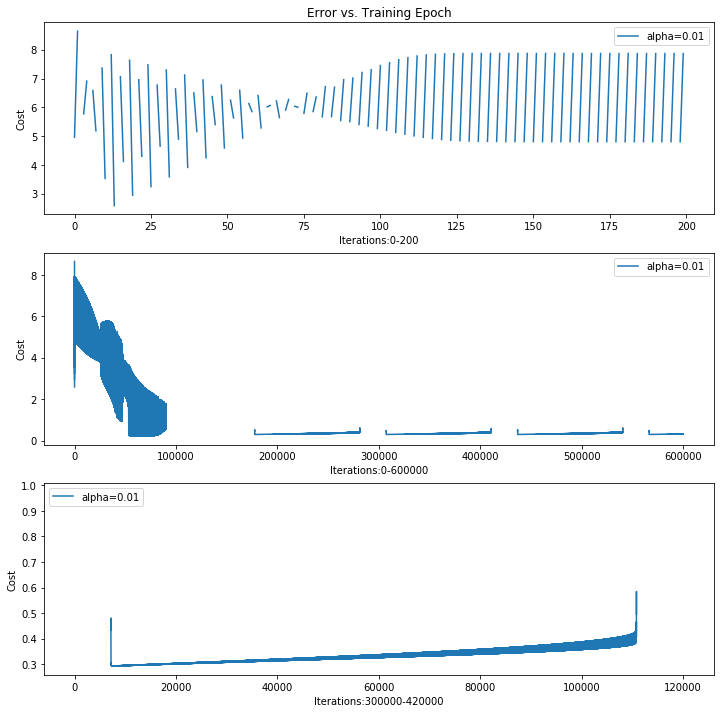

In [274]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,12))

ax1.plot(np.arange(200), _costs_[0:200], label="alpha=%.2f" % _alpha_)
ax1.set_xlabel('Iterations:0-200')
ax1.set_ylabel('Cost')
ax1.set_title('Error vs. Training Epoch')

ax2.plot(np.arange(600000), _costs_[0:600000], label="alpha=%.2f" % _alpha_)
ax2.set_xlabel('Iterations:0-600000')
ax2.set_ylabel('Cost')

ax3.plot(np.arange(120000), _costs_[300000:420000], label="alpha=%.2f" % _alpha_)
ax3.set_xlabel('Iterations:300000-420000')
ax3.set_ylabel('Cost')
# ax3.set_xlim([300000, 420000])

ax1.legend()
ax2.legend()
ax3.legend()

迭代次数在10w以后，cost才逐渐收敛，但也在周期性的震荡。

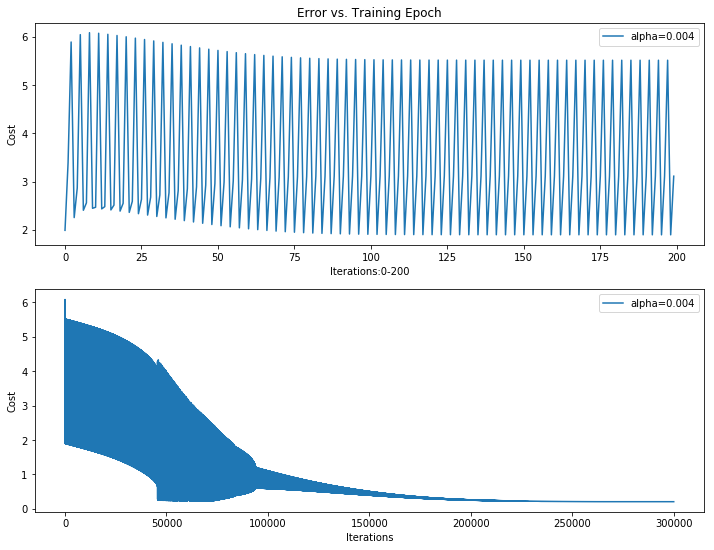

In [264]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9))

ax1.plot(np.arange(200), costs[0:200], label="alpha=%.3f" % alpha)
ax1.set_xlabel('Iterations:0-200')
ax1.set_ylabel('Cost')
ax1.set_title('Error vs. Training Epoch')

ax2.plot(np.arange(iterations), costs, label="alpha=%.3f" % alpha)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Cost')

ax1.legend()
ax2.legend()

迭代次数在10w以后，cost才逐渐收敛

## 使用scipy.optimize中的相关算法

In [291]:
def gradient(theta, X, y):
    """
    不执行梯度下降，只计算一个梯度步长
    """
    m = X.shape[0]
    # 为了兼容fmin_tnc算法中的参数格式，参数中的theta调整为行向量，即 array([0, 0, 0])
    # 列向量->行向量
    theta = theta.reshape(-1,1)      
    errors = sigmoid(X, theta) - y
    partial = np.dot(X.T, errors) 
    theta = partial / m
    # 转为行向量
    return theta.reshape(1,-1)

def cost(theta, X, y):
    m = X.shape[0]
    theta = theta.reshape(-1,1)   # 转成列向量
    h = sigmoid(X, theta)
    errors = -y*np.log(h) - (1-y)*np.log(1-h)
    j = np.sum(errors) / m
    return j

In [292]:
gradient(np.zeros(X.shape[1]).reshape(-1,1), X, y)

array([[ -0.1       , -12.00921659, -11.26284221]])

In [297]:
import scipy.optimize as opt
# theta = np.zeros(X.shape[1]).reshape(-1,1)    # invalid gradient vector from minimized function.
result = opt.fmin_tnc(func=cost, x0=np.zeros(X.shape[1]), fprime=gradient, args=(X, y))
result

(array([-25.87345428,   0.21193598,   0.20722506]), 51, 1)

In [348]:
cost(result[0], X, y)

0.20357132327605668

In [300]:
theta = result[0].reshape(-1,1)
theta

array([[-25.87345428],
       [  0.21193598],
       [  0.20722506]])

In [394]:
def predict(theta, X):
    h = sigmoid(X, theta)
    return np.array([0 if p<0.5 else 1 for p in h])

def accuracy(p, y):
    return len(filter(lambda x: x == True, (p == y.T)[0])) / len(y)

In [395]:
print("Train Accuracy: %d%%" % (accuracy(predict(theta, X), y)*100))

Train Accuracy: 89%


# Regularized logistic regression

正则化-逻辑回归的代价函数为：
$$J(\theta, x) = -\frac{1}{m}\sum_{i=1}^m \left[y^{(i)}log(h_\theta(x^{(i)})) + (1-y^{(i)})log(1-h_\theta(x^{(i)}))\right]
            + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$$
该函数是个凸函数。   

最小化目标$min_\theta(J(\theta))$不变，所以$J(\theta)$的对$\theta$偏导数为：
$$\frac{\partial}{\partial\theta_j}J(\theta) = \left(\frac{1}{m}\sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}\right) + \frac{\lambda}{m}\theta_j$$

$\theta$更新公式为：
$$\theta_j := \theta_j - \alpha\frac{\partial}{\partial\theta_j}J(\theta) :=\theta_j - \alpha\left(\sum_{i=1}^m \left[(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}\right] + \frac{\lambda}{m}\theta_j\right)$$

In [418]:
data2 = pd.read_csv(os.path.join(home, "ex2data2.txt"), names=["test1", "test2", "accepted"])
data2.tail()

,test1,test2,accepted
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0
117,0.632650,-0.030612,0


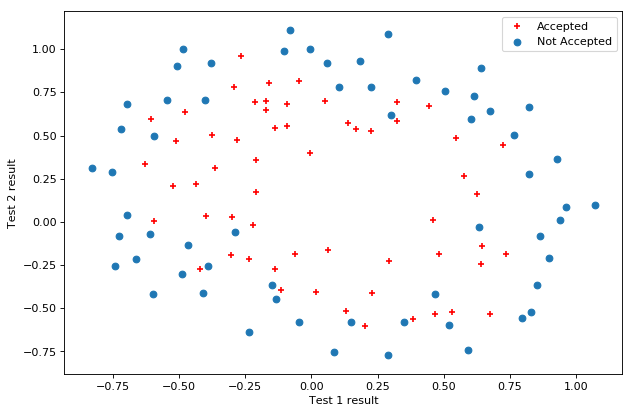

In [419]:
pos2 = data2[data2["accepted"] == 1]
neg2 = data2[data2["accepted"] == 0]

plt.figure(figsize=(9,6), dpi= 80)
plt.scatter(pos2.test1, pos2.test2, c='red', marker='+', label="Accepted")
plt.scatter(neg2.test1, neg2.test2, label="Not Accepted")
plt.xlabel('Test 1 result')
plt.ylabel('Test 2 result')
plt.legend()

该数据集时线性不可分的，所以仅使用原始的特征，无法利用逻辑回归这种线性技术来学习预测。     
一种办法是从原始特征的多项式中构造新特征，而新特征是线性可分的

### 构造多项式特征

In [420]:
degree = 5
x1 = data2['test1']
x2 = data2['test2']
for i in range(1, degree):
    for j in range(0, i):
        data2['f' + "%d%d" % (i,j)] = np.power(x1, i-j) * np.power(x2, j)

data2.insert(0, 'ones', 1)
del data2['test1']
del data2['test2']
data2.tail()

,ones,accepted,f10,f20,f21,f30,f31,f32,f40,f41,f42,f43
113,1,0,-0.720620,0.519293,-0.388227,-3.742131e-01,0.279764,-0.209153,2.696654e-01,-2.016035e-01,0.150720,-0.112679
114,1,0,-0.593890,0.352705,-0.293904,-2.094682e-01,0.174547,-0.145447,1.244011e-01,-1.036616e-01,0.086380,-0.071979
115,1,0,-0.484450,0.234692,-0.484096,-1.136964e-01,0.234520,-0.483743,5.508024e-02,-1.136134e-01,0.234349,-0.483390
116,1,0,-0.006336,0.000040,-0.006332,-2.544062e-07,0.000040,-0.006327,1.612020e-09,-2.542205e-07,0.000040,-0.006323
117,1,0,0.632650,0.400246,-0.019367,2.532156e-01,-0.012252,0.000593,1.601969e-01,-7.751437e-03,0.000375,-0.000018


In [421]:
y2 = np.array(data2["accepted"]).reshape(-1,1)
del data2['accepted']
X2 = np.array(data2)

In [422]:
X2.shape, y2.shape

((118, 11), (118, 1))

In [423]:
def gradient_reg(theta, X, y, lambdax):
    """
    不执行梯度下降，只计算一个梯度步长
    """
    m = X.shape[0]
    # 为了兼容fmin_tnc算法中的参数格式，参数中的theta调整为行向量，即 array([0, 0, 0])
    # 列向量->行向量
    theta = theta.reshape(-1,1)      
    errors = sigmoid(X, theta) - y
    reg = lambdax*theta / m
    theta = np.dot(X.T, errors) / m + reg
    # 转为行向量
    return theta.reshape(1,-1)

def cost_reg(theta, X, y, lambdax):
    m = X.shape[0]
    theta = theta.reshape(-1,1)   # 转成列向量
    h = sigmoid(X, theta)
    errors = -y*np.log(h) - (1-y)*np.log(1-h)
    j = np.sum(errors) / m + lambdax*np.sum(np.power(theta, 2))/(2*m)
    return j

In [479]:
lambda1 = 1
theta2_zero = np.zeros(X2.shape[1])
print("初始化的theta的代价是：%f" % cost_reg(theta2_zero, X2, y2, lambda1))       # 

初始化的theta的代价是：0.693147


In [480]:
gradient_reg(theta2_zero, X2, y2, lambda1)

array([[0.00847458, 0.01878809, 0.05034464, 0.01150133, 0.01835599,
        0.00732393, 0.00819244, 0.03934862, 0.00223924, 0.01286005,
        0.00309594]])

In [481]:
result2 = opt.fmin_tnc(func=cost_reg, x0=theta2_zero, fprime=gradient_reg, args=(X2, y2, lambda1))
result2

(array([ 0.49979256,  0.28684986, -1.56052967, -0.58730205,  0.01651304,
        -0.20664581, -0.39458359, -1.36621267,  0.02257614, -0.93628701,
         0.03159665]), 22, 1)

In [482]:
theta2 = result2[0]
theta2

array([ 0.49979256,  0.28684986, -1.56052967, -0.58730205,  0.01651304,
       -0.20664581, -0.39458359, -1.36621267,  0.02257614, -0.93628701,
        0.03159665])

In [483]:
cost_reg(theta2, X2, y2, lambda1)

0.6238050189296066

In [484]:
print("Train Accuracy: %d%%" % (accuracy(predict(theta2, X2), y2)*100))

Train Accuracy: 66%


In [511]:
lambdas = [0, 1, 10, 20, 40, 60, 80, 100]
accuracies = list()
    
def lambda_accuracy(X, y):
    for lx in lambdas:
        rlt = opt.fmin_tnc(func=cost_reg, x0=np.zeros(X.shape[1]), fprime=gradient_reg, args=(X, y, lx))
        th = rlt[0]
        acc = accuracy(predict(th, X), y)*100
        accuracies.append(acc)
    for i in range(len(lambdas)):
        print("λ=%d, accuracy=%d%%" % (lambdas[i], accuracies[i]))
    
lambda_accuracy(X2, y2)

λ=0, accuracy=77%
λ=1, accuracy=66%
λ=10, accuracy=63%
λ=20, accuracy=66%
λ=40, accuracy=62%
λ=60, accuracy=61%
λ=80, accuracy=57%
λ=100, accuracy=54%


可以看到随着正则化参数λ的增大，准确率是逐渐降低的(λ=20时为何突然增大，原因未知)，过拟合程度逐渐减轻，甚至于欠拟合。

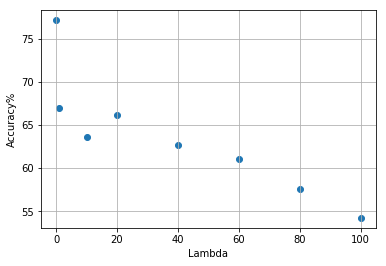

In [512]:
plt.scatter(lambdas, accuracies)
plt.grid(True)
plt.xlabel("Lambda")
plt.ylabel("Accuracy%")

## 实现随机梯度下降和小批量梯度下降
 - [如何理解随机梯度下降 - zhihu](https://www.zhihu.com/question/264189719)

In [655]:
print("零值theta对应的cost值是：%f" % compute_cost(X, y, np.zeros(X.shape[1]).reshape(-1,1)))

零值theta对应的cost值是：0.693147


In [656]:
def stochastic_gd(X, y, theta, alpha, iterations):
    """
    随机梯度下降(该算法实现存在问题)
    """
    m = X.shape[0]
    for l in range(iterations):
        for i in range(m):
            error = sigmoid(X[i], theta) - y[i]
            theta -= alpha * X[i].reshape(-1,1) * error / m        # 看公式不应该除以m，但不除不收敛
    return theta

In [647]:
sgd_theta = np.zeros(X.shape[1]).reshape(-1,1)
stochastic_gd(X, y, sgd_theta, 0.005, 30000)     # 300w次迭代 
sgd_theta

array([[-6.38746604],
       [ 0.06183096],
       [ 0.05675357]])

In [648]:
compute_cost(X, y, sgd_theta)         

0.37671418369834375

In [651]:
def mini_batch_gd(X, y, theta, alpha, iterations, batch_size):
    """
    Mini Batch梯度下降(该算法实现存在问题)
    """
    m = X.shape[0]
    for l in range(iterations):
        for i in np.arange(0, m, batch_size):
            error = sigmoid(X[i:i+batch_size], theta) - y[i:i+batch_size]
            theta -= alpha * np.dot(X[i:i+batch_size].T, error) / m  # 看公式不应该除以m，而是除以batch_size，但除以batch_size不收敛
    return theta

In [652]:
mb_theta = np.zeros(X.shape[1]).reshape(-1,1)
mini_batch_gd(X, y, mb_theta, 0.005, 30000*5, 5)  # 300w次迭代     
mb_theta

array([[-14.18737767],
       [  0.12259651],
       [  0.11775003]])

In [653]:
compute_cost(X, y, mb_theta)

0.24728839018673646

## 特征标准化

In [659]:
def normalize(df):
    return (df - df.mean()) / df.std()

In [660]:
Xn = data1[["exam1score", "exam2score"]]
Xn = normalize(Xn)
Xn.insert(0,"ones", np.ones(Xn.shape[0]))       # DataFrame.insert(loc, column, value, allow_duplicates=False)
Xn.tail()

,ones,exam1score,exam2score
95,1.0,0.917087,-0.960121
96,1.0,-1.201681,1.123720
97,1.0,1.730412,0.137407
98,1.0,-0.529558,-0.069422
99,1.0,0.469294,1.254269


In [668]:
Xn = np.array(Xn)

In [677]:
def stochastic_gd_correct(X, y, theta, alpha, iterations):
    """
    随机梯度下降
    """
    m = X.shape[0]
    for l in range(iterations):
        for i in range(m):
            error = sigmoid(X[i], theta) - y[i]
            theta -= alpha * X[i].reshape(-1,1) * error 
    return theta

In [678]:
sgd_theta_c = np.zeros(Xn.shape[1]).reshape(-1,1)
stochastic_gd_correct(Xn, y, sgd_theta_c, 0.005, 300)     # 总共3w次迭代 
sgd_theta_c

array([[1.41541196],
       [3.36027787],
       [3.11539345]])

In [679]:
compute_cost(Xn, y, sgd_theta_c)   

0.20654959667246417

In [680]:
def mini_batch_gd_correct(X, y, theta, alpha, iterations, batch_size):
    """
    Mini Batch梯度下降
    """
    m = X.shape[0]
    for l in range(iterations):
        for i in np.arange(0, m, batch_size):
            error = sigmoid(X[i:i+batch_size], theta) - y[i:i+batch_size]
            theta -= alpha * np.dot(X[i:i+batch_size].T, error) / batch_size
    return theta

In [683]:
mb_theta_c = np.zeros(Xn.shape[1]).reshape(-1,1)
mini_batch_gd(Xn, y, mb_theta_c, 0.005, 2000, 5)  # 总共4w次迭代     
mb_theta_c

array([[0.46648217],
       [1.28560284],
       [1.15278514]])

In [684]:
compute_cost(Xn, y, mb_theta_c)

0.312668101309527

<h3>特征标准化后，梯度下降的收敛速度比没有标准化快100倍以上</h3>

### 较好的随机梯度下降开源实现
 - [Gradient Descent in Python](https://towardsdatascience.com/gradient-descent-in-python-a0d07285742f)
 - [**Stochastic Gradient Descent (SGD) with Python**](https://www.pyimagesearch.com/2016/10/17/stochastic-gradient-descent-sgd-with-python/)    